# EDA using Scatterplots
This notebook explores the GDP and CO2 emissions datasets contained in `..\data\final`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)
os.makedirs('../plots/scatterplots', exist_ok=True)

In [2]:
df = pd.read_csv('../data/final/gdp_co2_emissions.csv')

 ---

Quick inspection

In [3]:
df.head()

,Country Name,Country Code,Continent,Year,CO2 emissions,CO2 emissions per capita,GDP,GDP per capita,GDP growth (annual %),log (GDP pc),log (CO2 pc)
0,Afghanistan,AFG,Asia,2000,1047127.94,0.052017,6.206548e+09,1617.826475,NaN,7.388839,-2.956177
1,Afghanistan,AFG,Asia,2001,1069098.00,0.052706,5.621148e+09,1454.110782,-9.431974,7.282150,-2.943032
2,Afghanistan,AFG,Asia,2002,1341065.00,0.062731,7.228796e+09,1774.308743,28.600001,7.481166,-2.768904
3,Afghanistan,AFG,Asia,2003,1559679.00,0.068608,7.867263e+09,1815.928200,8.832278,7.504352,-2.679340
4,Afghanistan,AFG,Asia,2004,1237247.00,0.052513,7.978516e+09,1776.918207,1.414118,7.482636,-2.946689


 ---
## Scatter Plots
**Scatter plots** (standard scale) between GDP per capita and CO2 emissions per capita to understand if there is linear correlation.

The [Environmental Kuznets Curve (EKC)](https://en.wikipedia.org/wiki/Kuznets_curve) theory suggests that a developing country initially produce high emissions, they reach a peak, but then decline as the economy becomes more efficient. In a standard scatter plot this results in an inverted _U-shape_.

In [4]:
num_ranges = 3
min_year = df['Year'].min()
max_year = df['Year'].max()
print(f"Data covers years from {min_year} to {max_year}")

Data covers years from 1990 to 2024


In [5]:
unique_continents = sorted([c for c in df['Continent'].unique() if pd.notna(c)])
colors = sns.color_palette('tab10', n_colors=len(unique_continents))
continent_palette = dict(zip(unique_continents, colors))

In [6]:
def create_scatterplots(data, x_col, y_col, title, output_path, num_ranges=3, palette=None, 
                        filter_condition=None, hue_col=None, color='darkblue', figsize=(22, 6)):
    
    if filter_condition is not None:
        df_filtered = filter_condition(data).copy()
    else:
        df_filtered = data.copy()
    
    min_year = df_filtered['Year'].min()
    max_year = df_filtered['Year'].max()
    
    fig, axes = plt.subplots(1, num_ranges, figsize=figsize)

    if num_ranges == 1: axes = [axes] # Ensure axes is always a list for consistent indexing

    for i in range(num_ranges):
        range_start = min_year + i * (max_year - min_year) // num_ranges
        range_end = min_year + (i + 1) * (max_year - min_year) // num_ranges
        
        df_subset = df_filtered[(df_filtered['Year'] >= range_start) & 
                                (df_filtered['Year'] < range_end)]
        
        agg_dict = {x_col: 'mean', y_col: 'mean'}
        if hue_col:
            agg_dict[hue_col] = 'first'
        df_subset = df_subset.groupby('Country Name').agg(agg_dict).reset_index()
        
        if hue_col:
            sns.scatterplot(data=df_subset, x=x_col, y=y_col, 
                            alpha=0.8, hue=hue_col, palette=palette, ax=axes[i])
            axes[i].get_legend().remove()
        else:
            sns.scatterplot(data=df_subset, x=x_col, y=y_col, 
                            alpha=0.8, color=color, ax=axes[i])
            
        if len(df_subset) < 60:
            for _, row in df_subset.iterrows():
                axes[i].annotate(
                    row['Country Name'], 
                    xy=(row[x_col], row[y_col]),      # Point coordinates
                    xytext=(0, 7),                    # Offset of 7 points upwards
                    textcoords='offset points',       # Indicates that (0, 7) are points, not data coordinates
                    ha='center',                      # Centers horizontally
                    va='bottom',                      # Aligns the base of the text above the offset
                    fontsize=8, 
                    alpha=0.3
                )     
        axes[i].set_title(f'{range_start}-{range_end}', fontsize=12, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
        
    if hue_col:
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, title=hue_col, loc='center left', 
                   bbox_to_anchor=(0.01, 0.5), fontsize=10, frameon=False)

    plt.subplots_adjust(left=0.12, top=0.85, wspace=0.3)
    fig.suptitle(title, fontsize=16, x=0.5)
    fig.tight_layout(rect=[0.12, 0.03, 1, 0.95]) 
    fig.savefig(output_path, dpi=300)
    plt.show()

### 1. Scatter Plots across all countries (1960-2024)

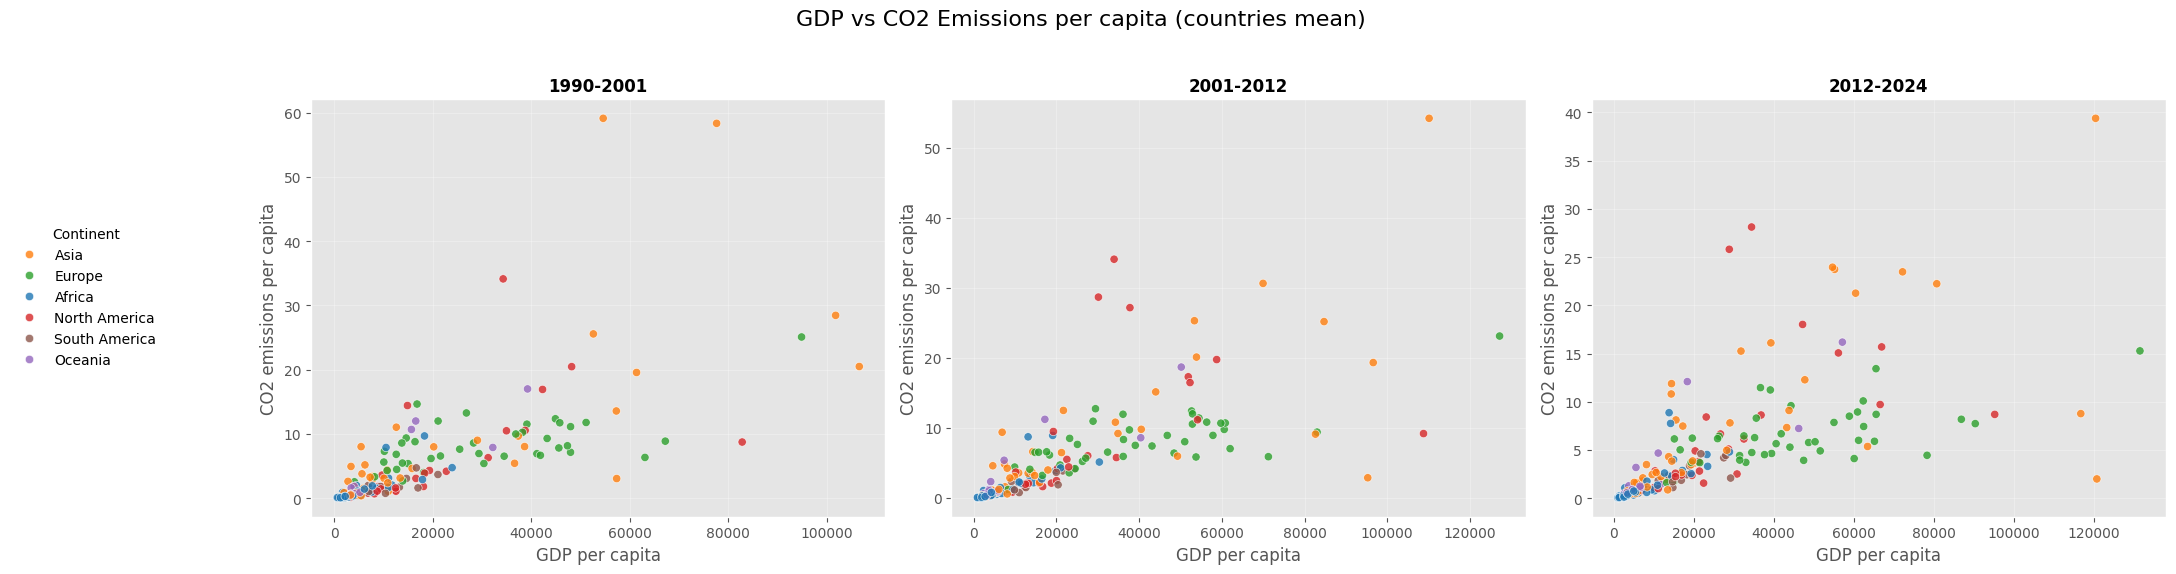

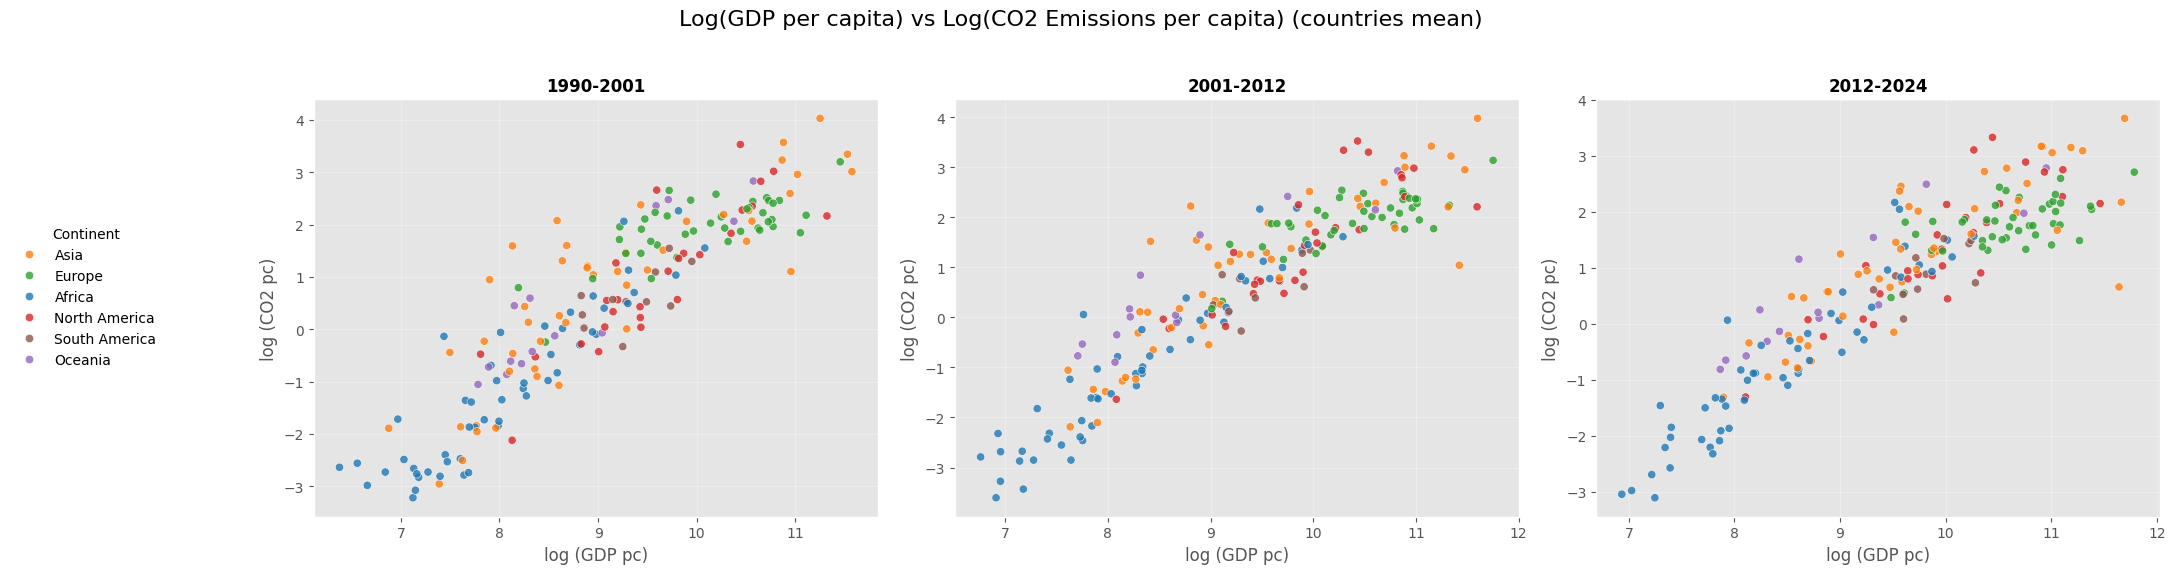

In [7]:
# Create scatterplots for all countries

# Plot 1: GDP vs CO2 emissions
create_scatterplots(
    data=df,
    x_col='GDP per capita',
    y_col='CO2 emissions per capita',
    title='GDP vs CO2 Emissions per capita (countries mean)',
    output_path='../plots/scatterplots/scatterplot_gdp_pc__co2_pc.png',
    palette=continent_palette,
    hue_col='Continent'
)

# Plot 2: Log(GDP per capita) vs Log(CO2 emissions per capita)
create_scatterplots(
    data=df,
    x_col='log (GDP pc)',
    y_col='log (CO2 pc)',
    title='Log(GDP per capita) vs Log(CO2 Emissions per capita) (countries mean)',
    output_path='../plots/scatterplots/scatterplot_log_gdp_pc__log_co2_pc.png',
    palette=continent_palette,
    hue_col='Continent'
)

The Standard-Scaled plots (top) show a heavy concentration of data points near the origin (low income, low emissions), that is because of the distribution of GDP and CO2 which usually have "power" distribution (a few countries have massive values, many have very small ones).

By applying the Log-Scale (bottom), their relationship is linearized, revealing a much clearer structure and allowing for better analysis of the low income, low emission countries. 

 --- 
### 2. Scatter plots 30 richest countries (in 2024)

In [8]:
df_2024 = df[df['Year'] == 2024]
top30_countries = df_2024.sort_values(by='GDP', ascending=False)['Country Name'].unique()[:30].tolist()
print("30 Richest countries by GDP in 2024:", top30_countries)
df_top30 = df[df['Country Name'].isin(top30_countries)].sort_values(by=['GDP', 'Year'], ascending=False)


30 Richest countries by GDP in 2024: ['United States', 'China', 'Japan', 'Germany', 'India', 'United Kingdom', 'France', 'Italy', 'Brazil', 'South Korea', 'Canada', 'Australia', 'Russia', 'Spain', 'Mexico', 'Turkey', 'Indonesia', 'Netherlands', 'Saudi Arabia', 'Switzerland', 'Poland', 'Argentina', 'Sweden', 'Nigeria', 'Iran', 'Belgium', 'Ireland', 'Egypt', 'Thailand', 'United Arab Emirates']


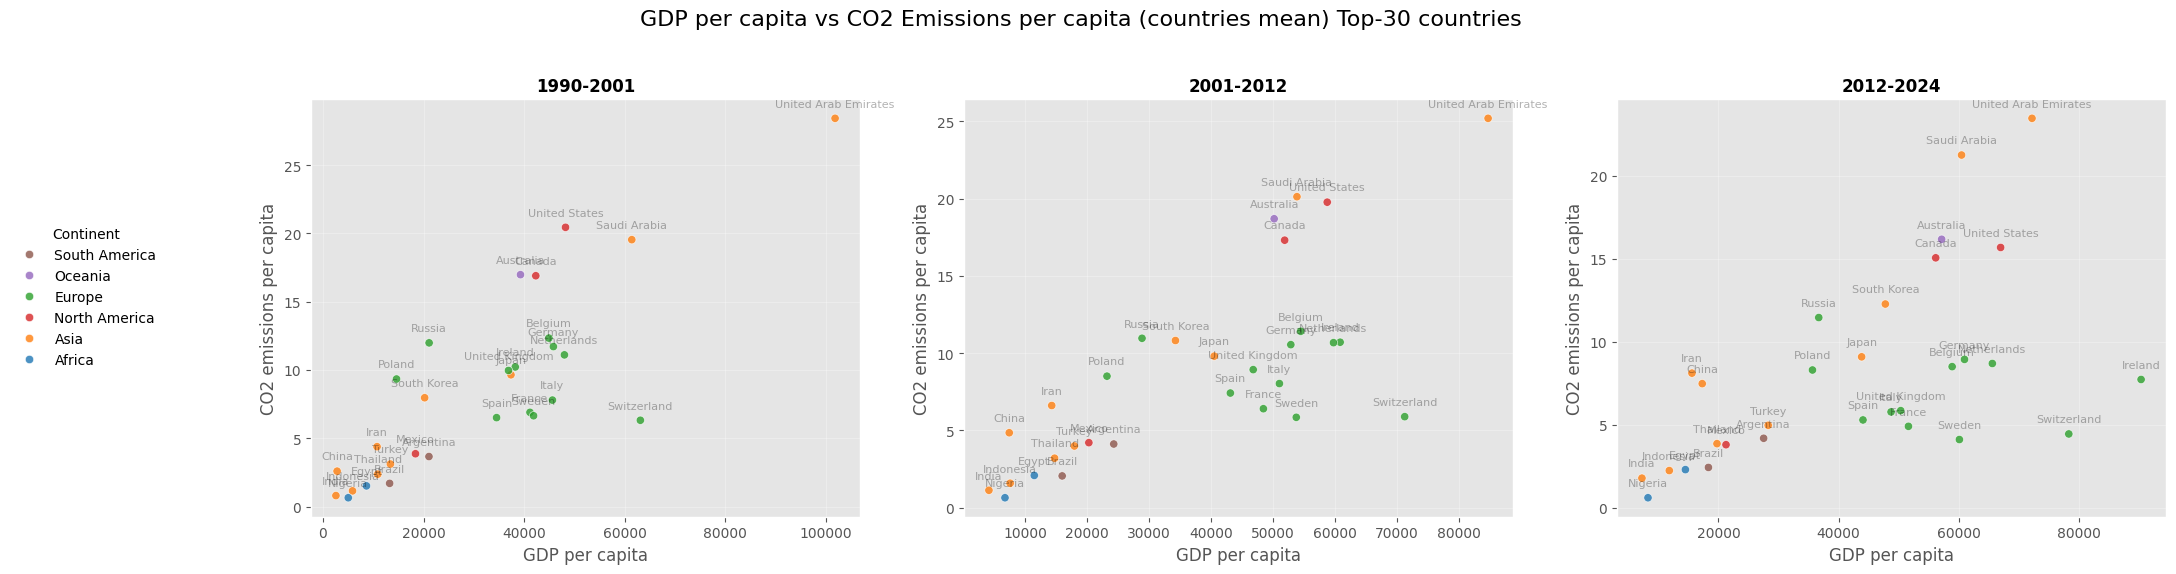

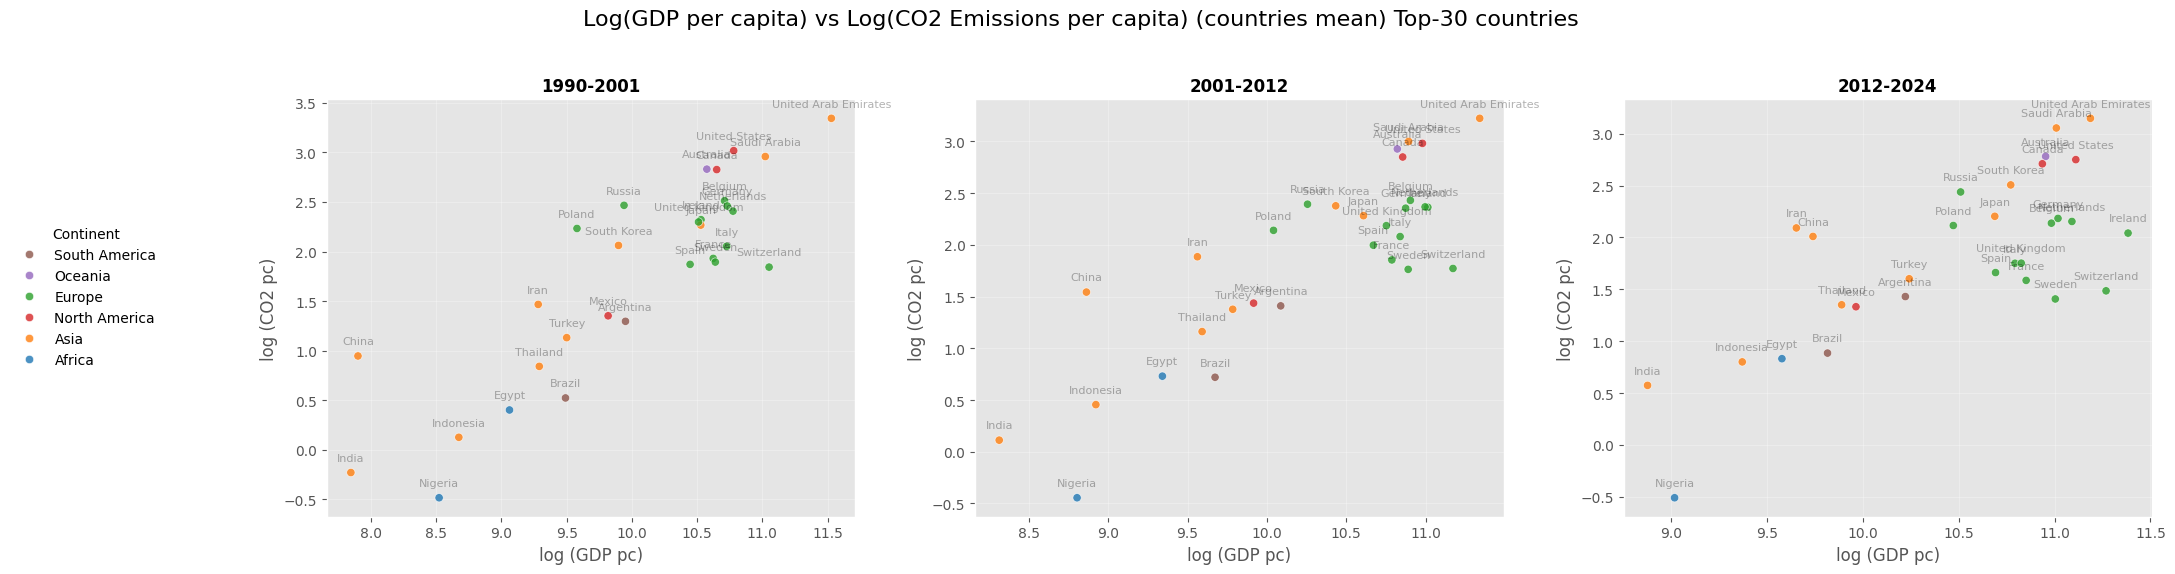

In [9]:
# Function to filter top 30 countries
def filter_top30(data):
    return data[data['Country Name'].isin(top30_countries)]

# Plot 1: GDP per capita vs CO2 emissions per capita (Top-30)
create_scatterplots(
    data=df_top30,
    x_col='GDP per capita',
    y_col='CO2 emissions per capita',
    title='GDP per capita vs CO2 Emissions per capita (countries mean) Top-30 countries',
    output_path='../plots/scatterplots/scatterplot_gdp_pc__co2_pc_top_30.png',
    filter_condition=filter_top30,
    hue_col='Continent',
    palette=continent_palette
)
# Plot 2: log GDP vs log CO2 emissions (Top-30)
create_scatterplots(
    data=df_top30,
    x_col='log (GDP pc)',
    y_col='log (CO2 pc)',
    title='Log(GDP per capita) vs Log(CO2 Emissions per capita) (countries mean) Top-30 countries',
    output_path='../plots/scatterplots/scatterplot_log_gdp_pc__log_co2_pc_top_30.png',
    filter_condition=filter_top30,
    hue_col='Continent',
    palette=continent_palette
)

 ---
### 3. Scatterplots across all continents

In [10]:
continents = df['Continent'].unique()
continents = [c for c in continents if pd.notna(c)] 
continent_colors = sns.color_palette('tab10', n_colors=len(continents))

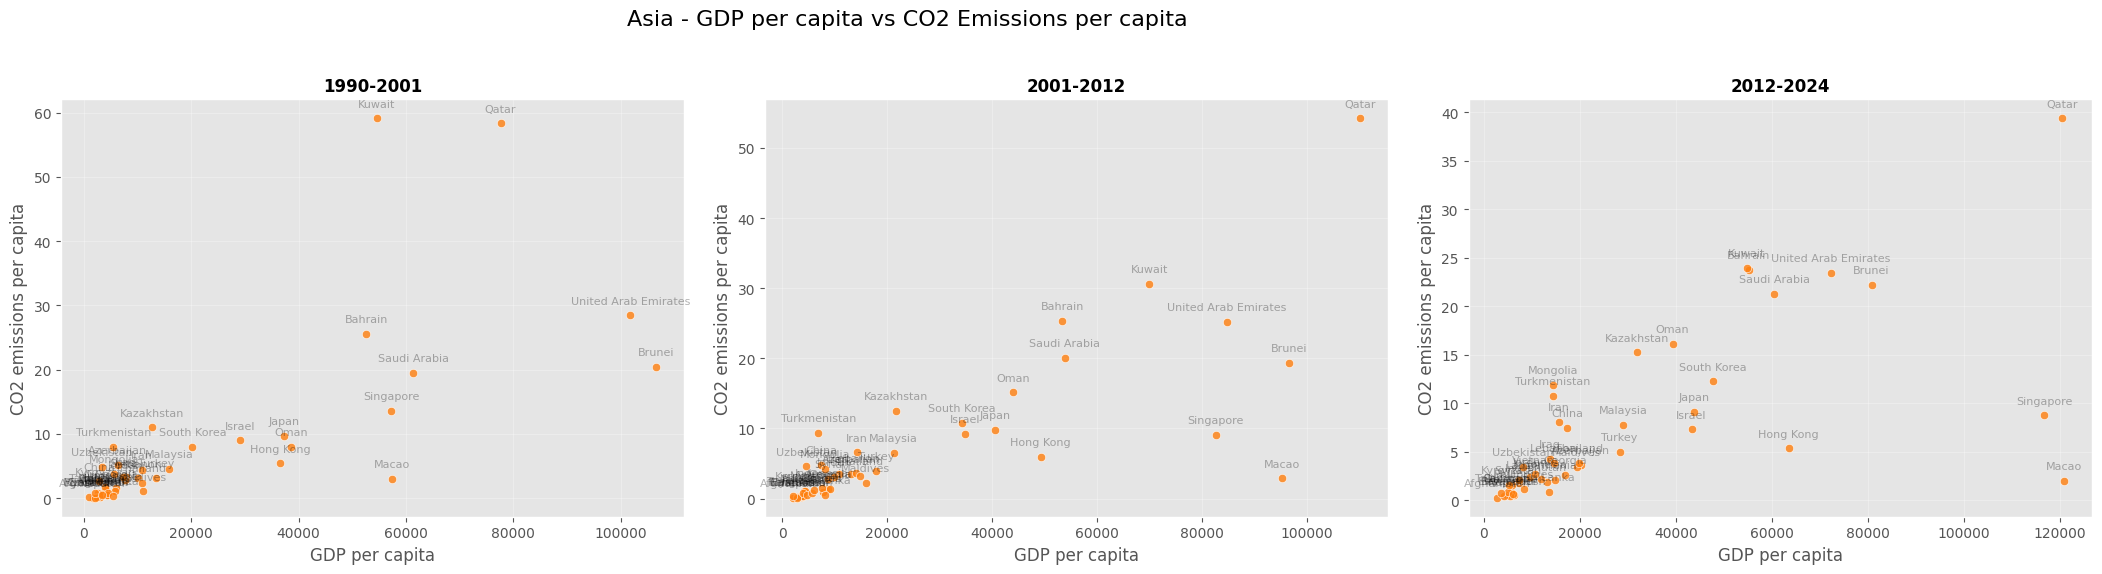

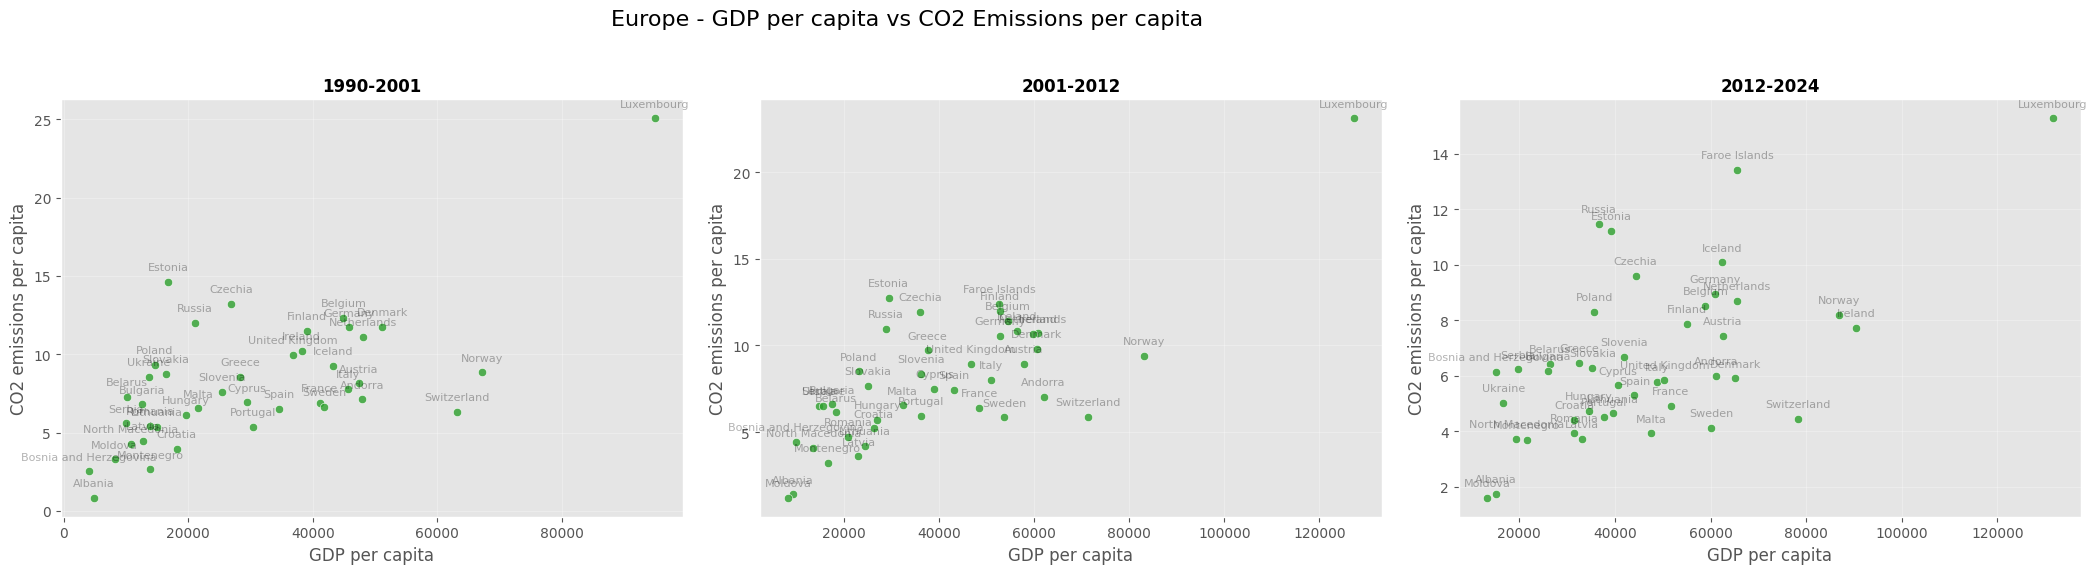

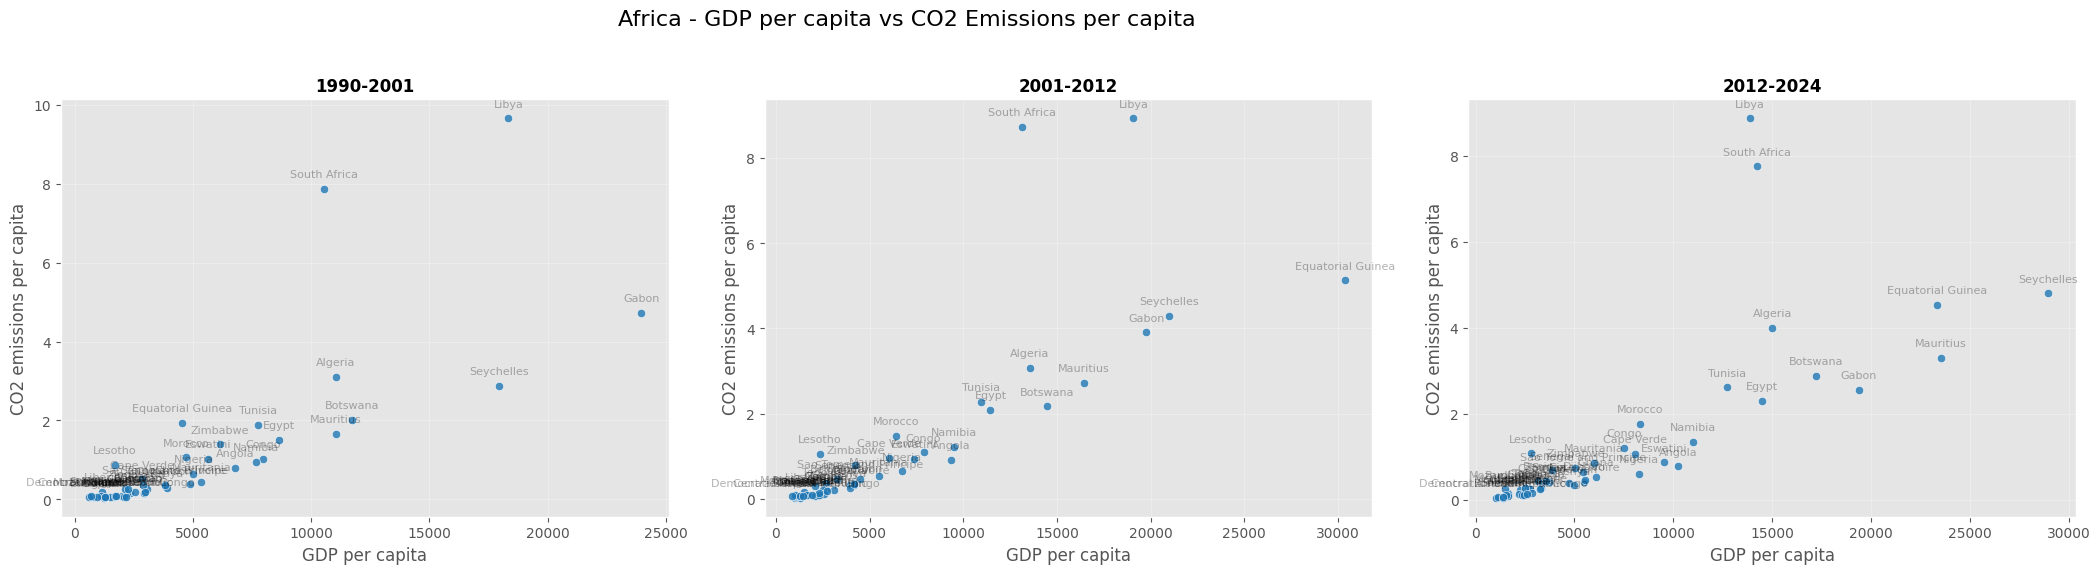

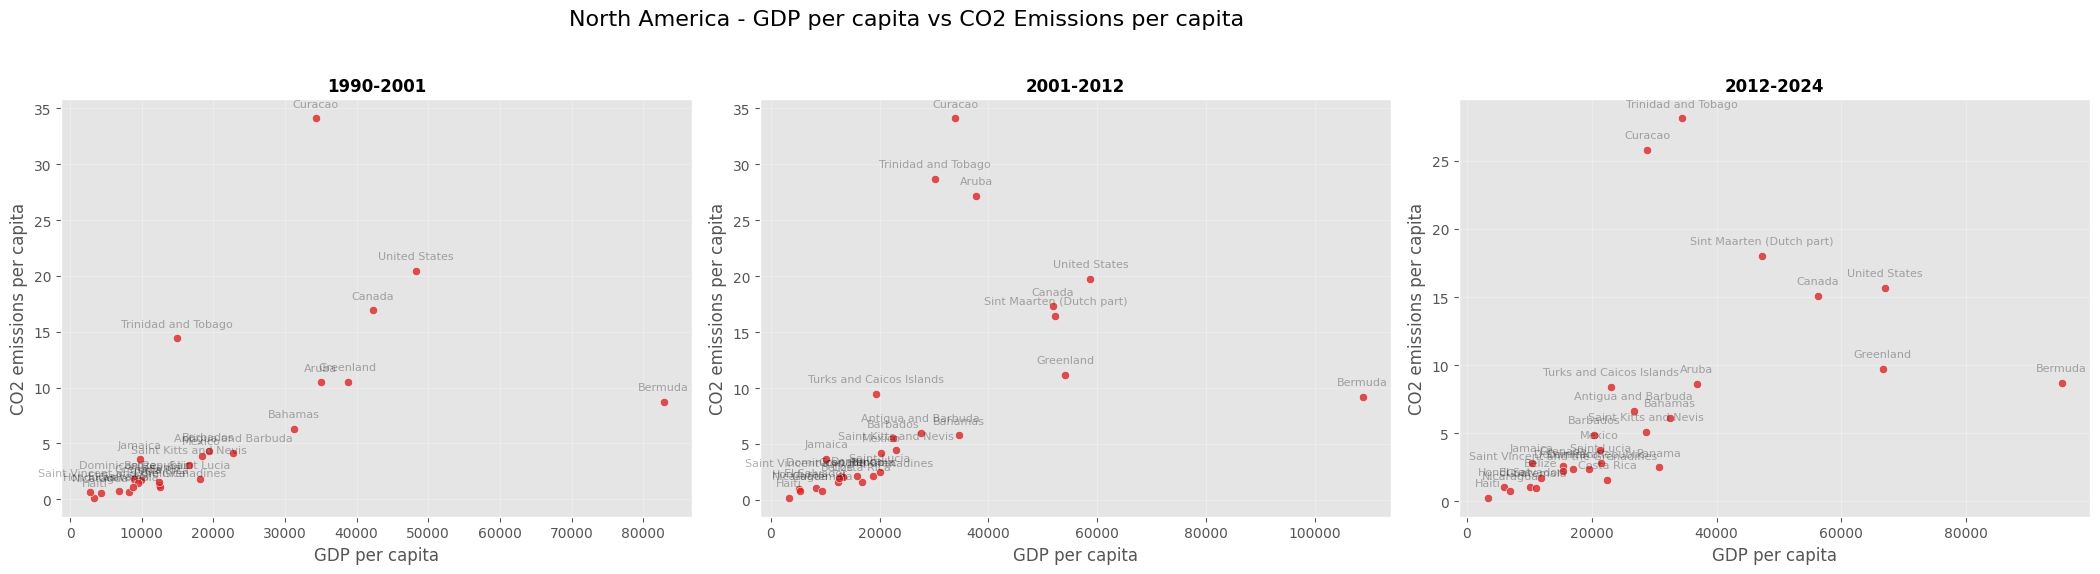

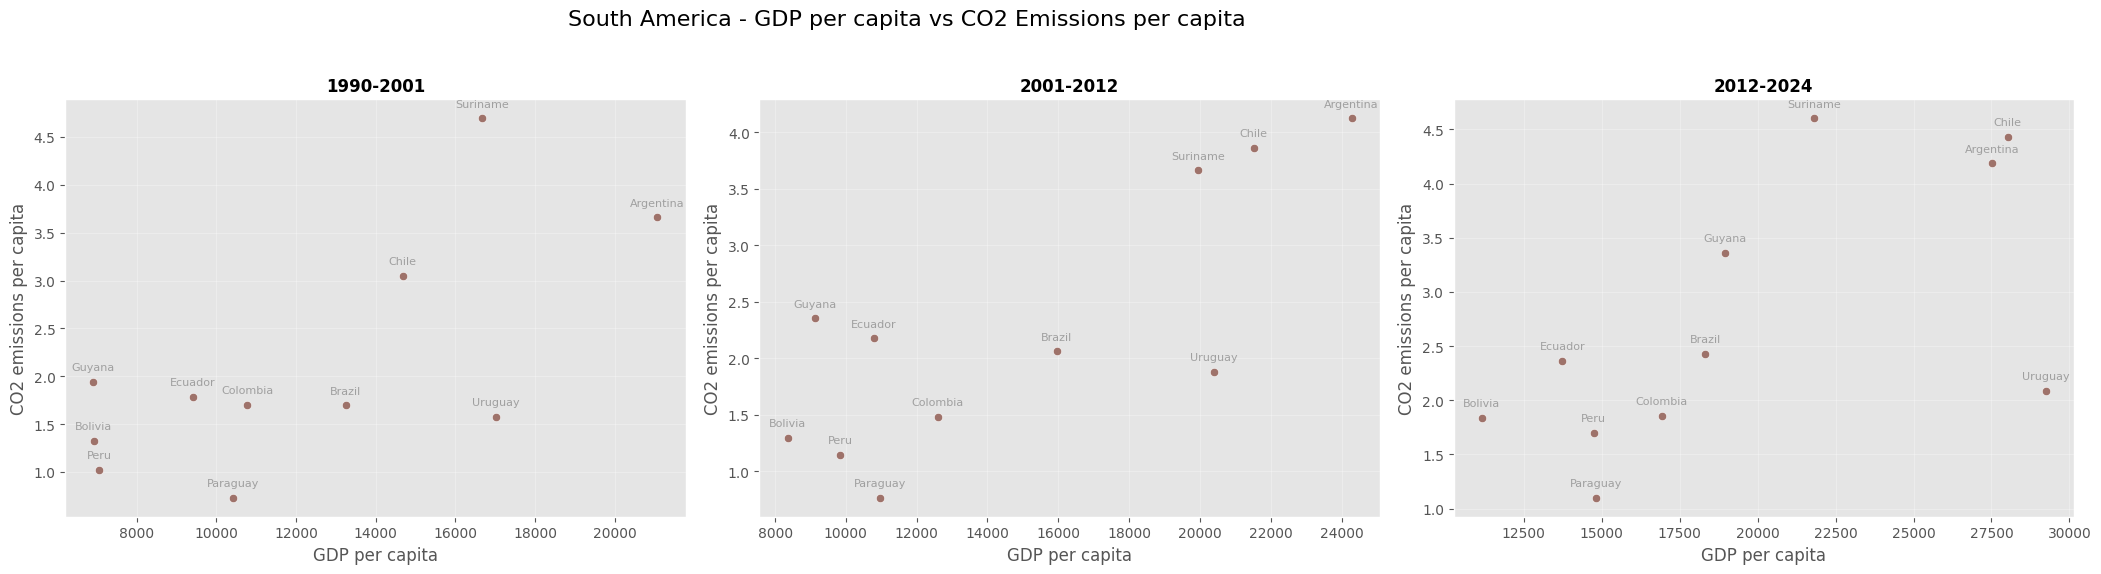

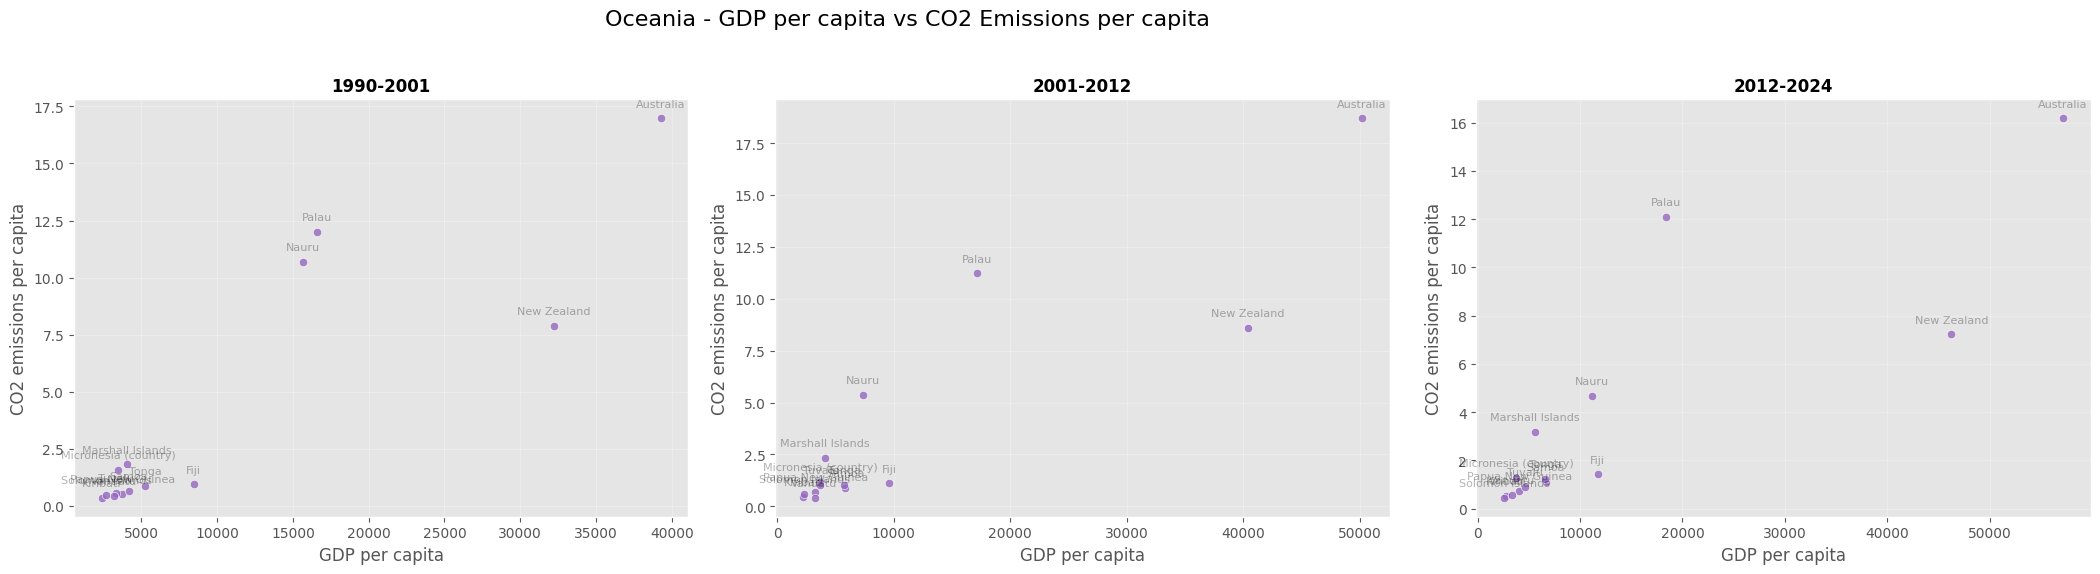

In [11]:
# Create scatterplots for each continent (GDP per capita vs CO2 emissions per capita)
for continent in continents:
    current_color = continent_palette[continent]
    create_scatterplots(
        data=df,
        x_col='GDP per capita',
        y_col='CO2 emissions per capita',
        title=f'{continent} - GDP per capita vs CO2 Emissions per capita',
        output_path=f'../plots/scatterplots/scatterplot_gdp_pc__co2_pc_{continent.lower().replace(" ", "_")}.png',
        filter_condition=lambda d, c=continent: d[d['Continent'] == c],
        figsize=(24, 6),
        color=current_color
    )

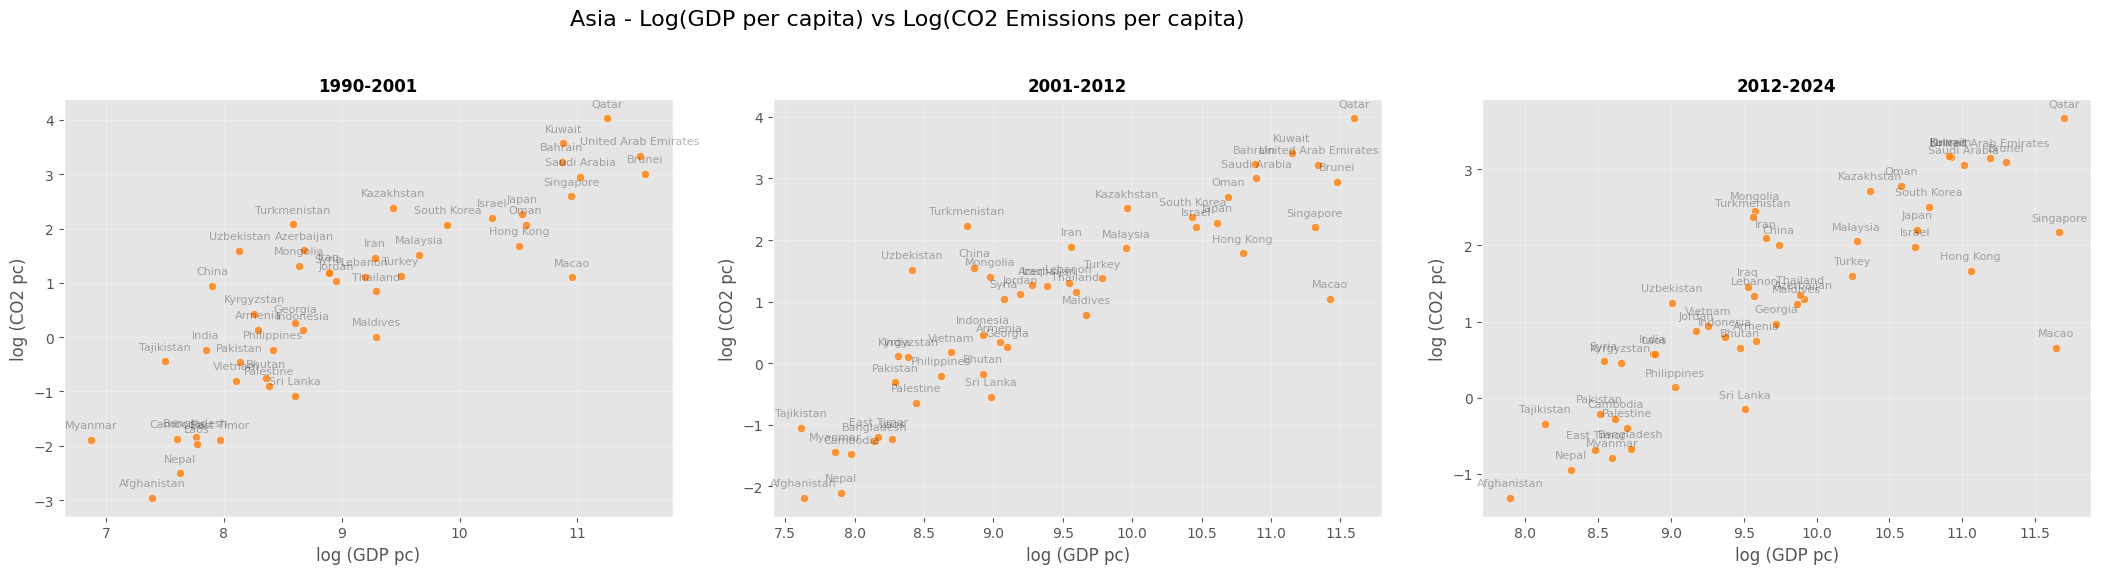

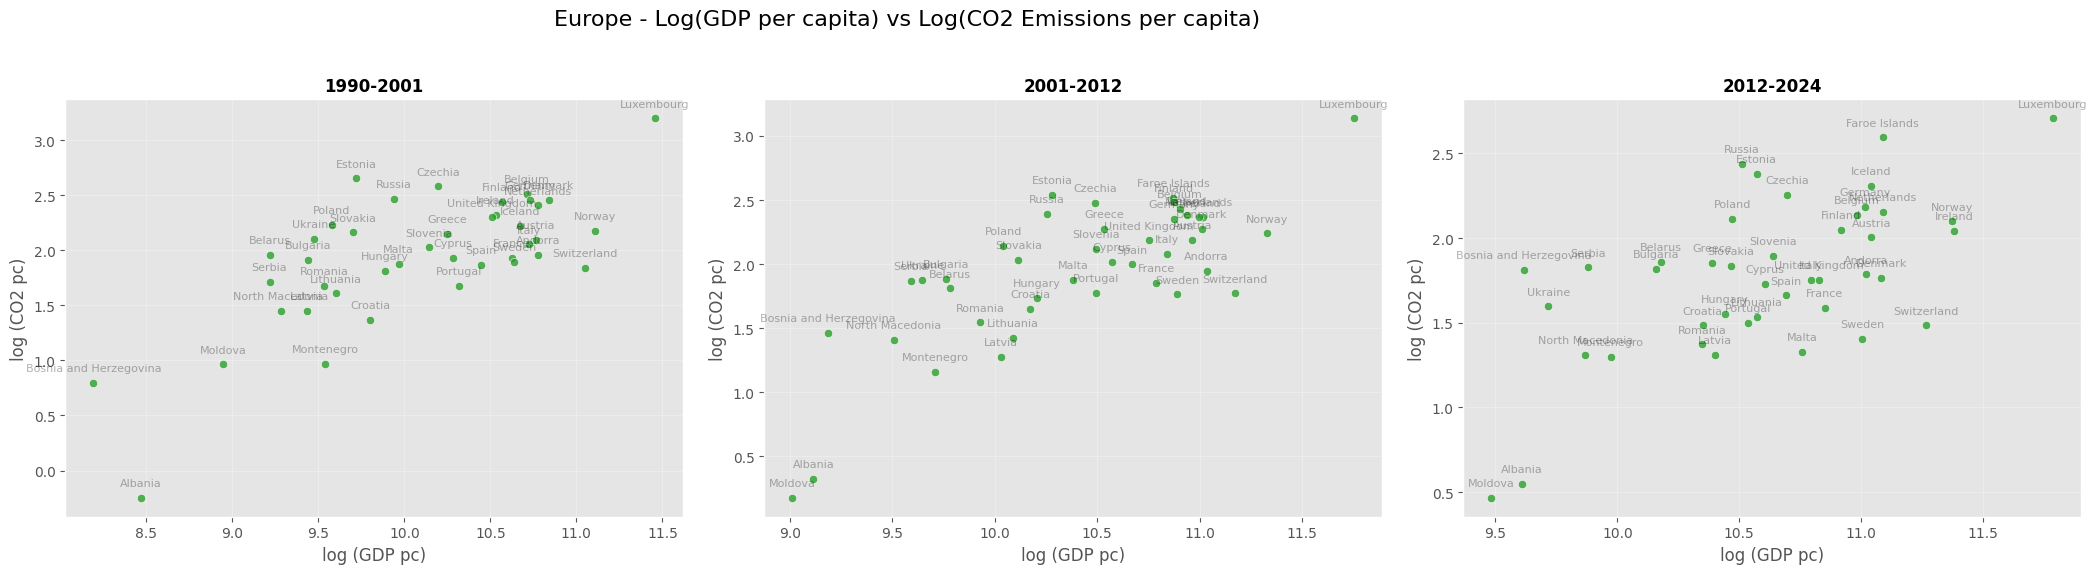

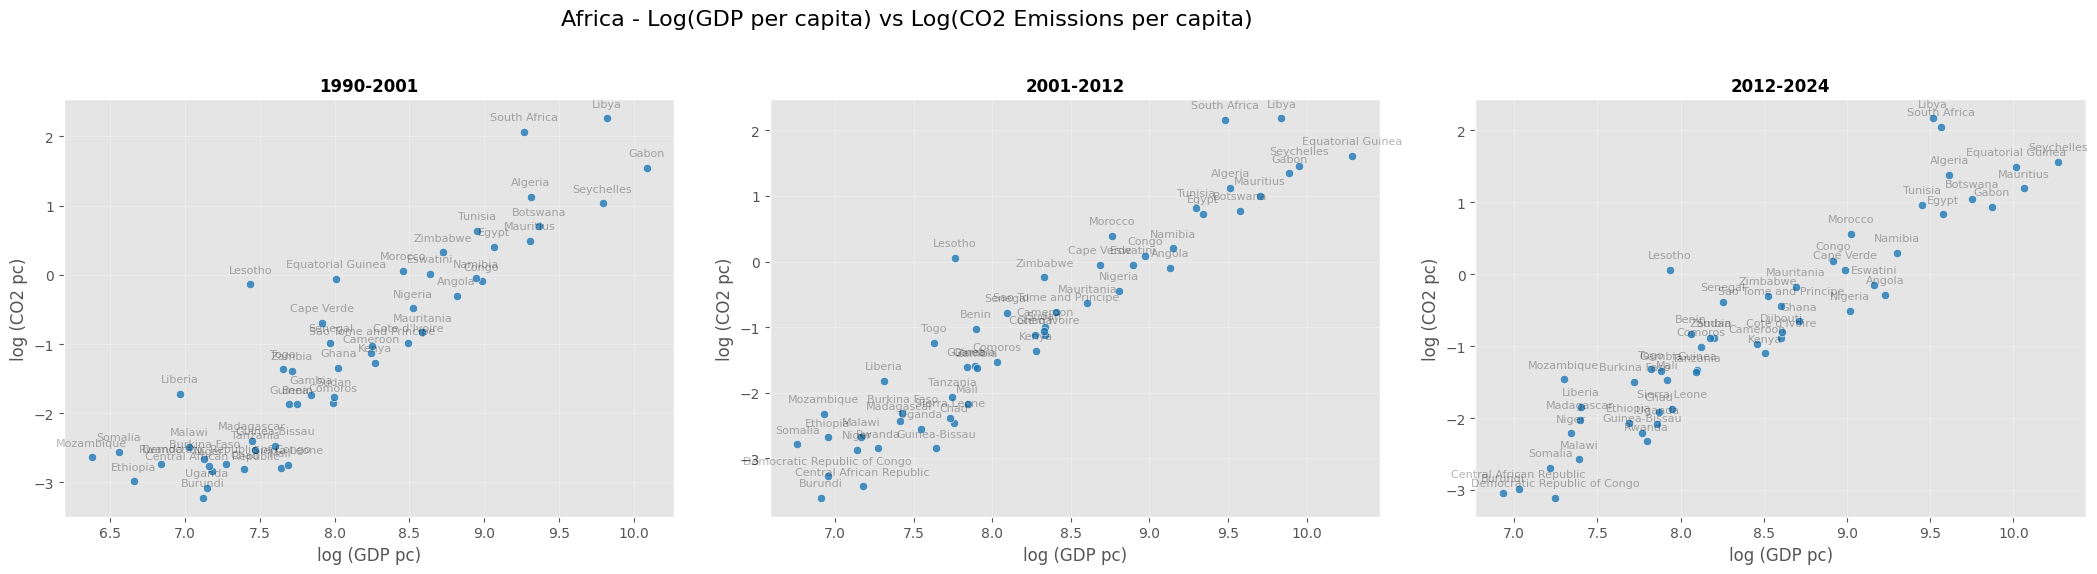

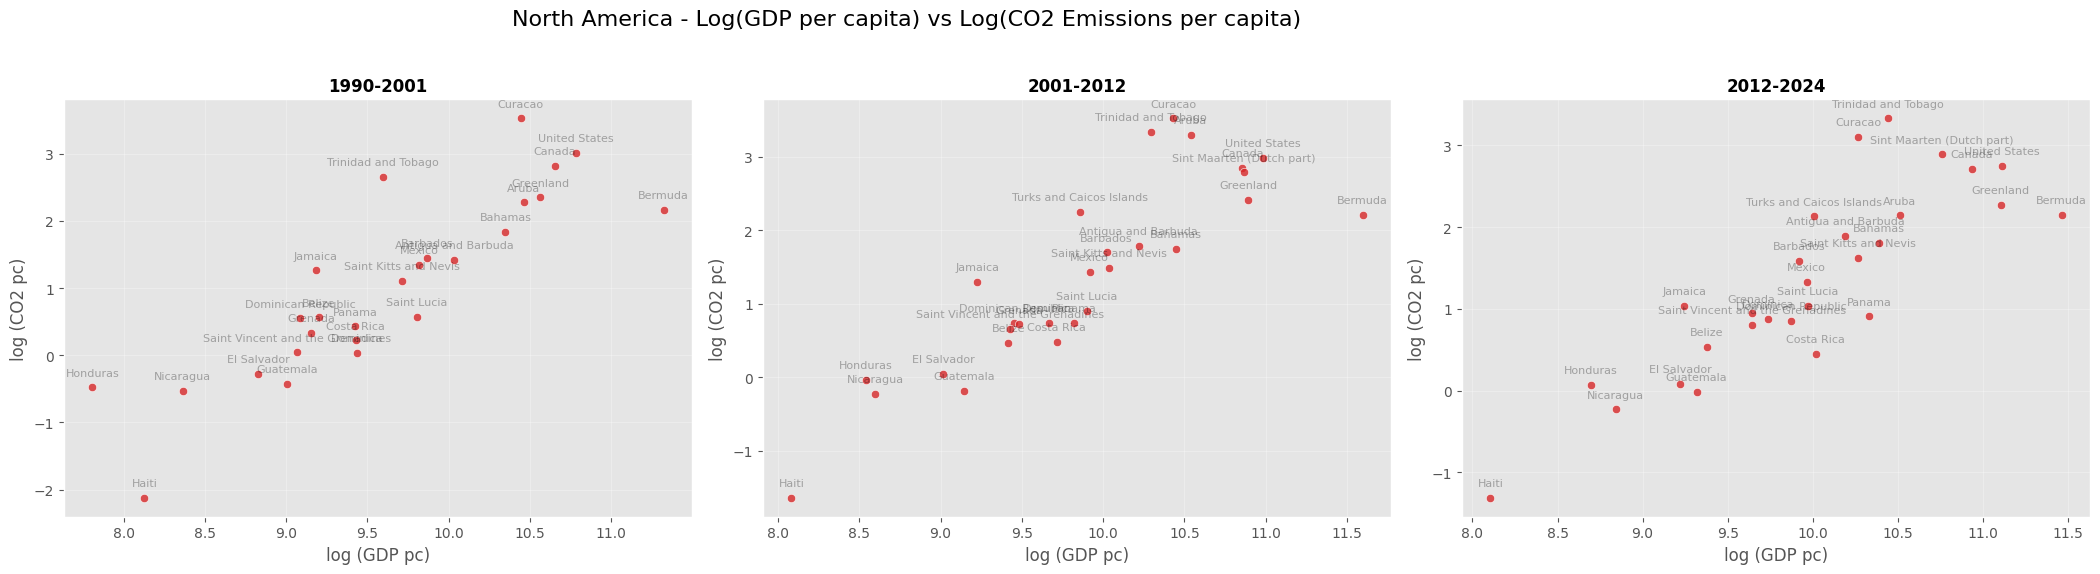

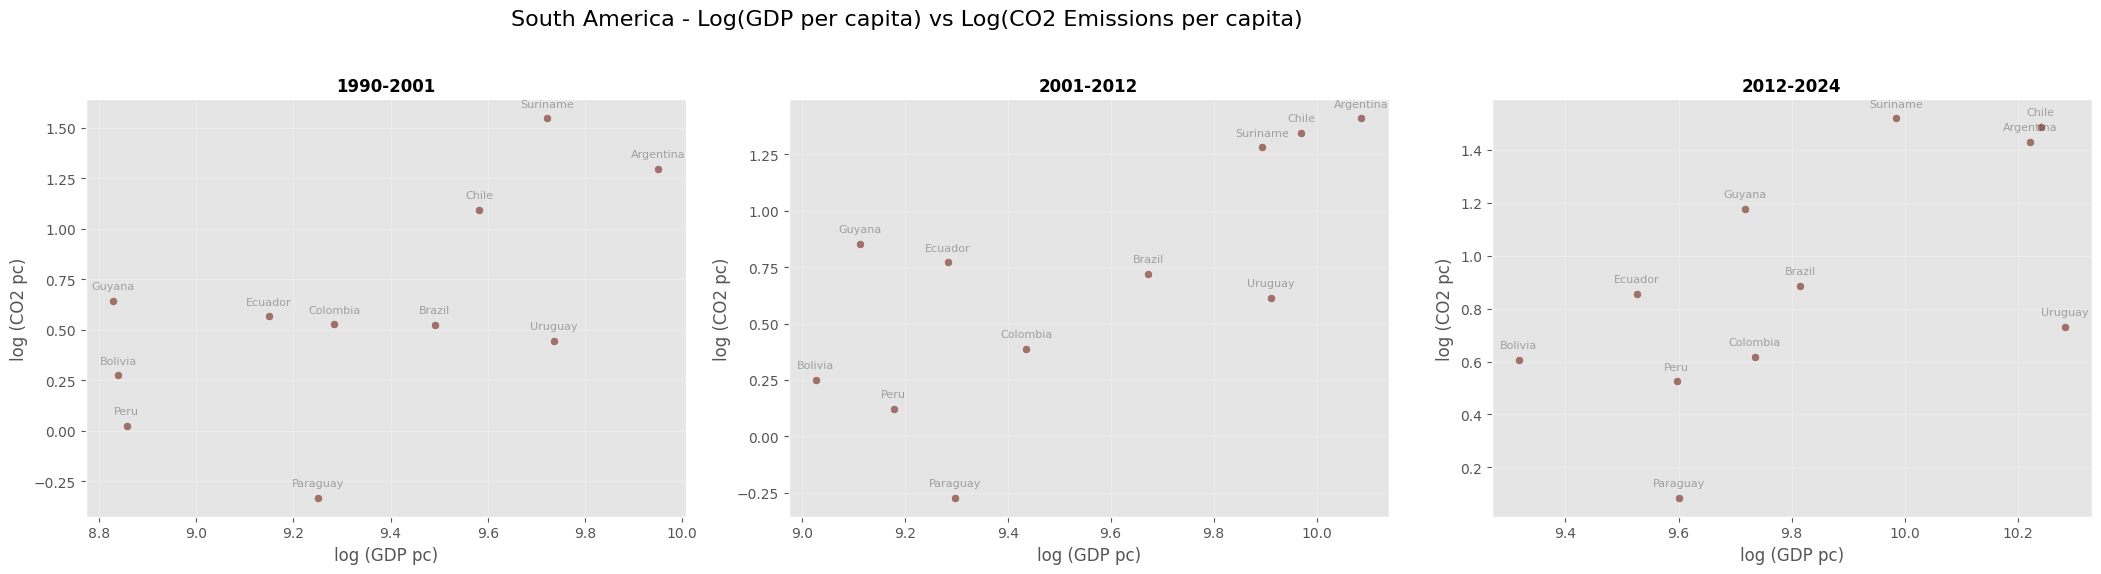

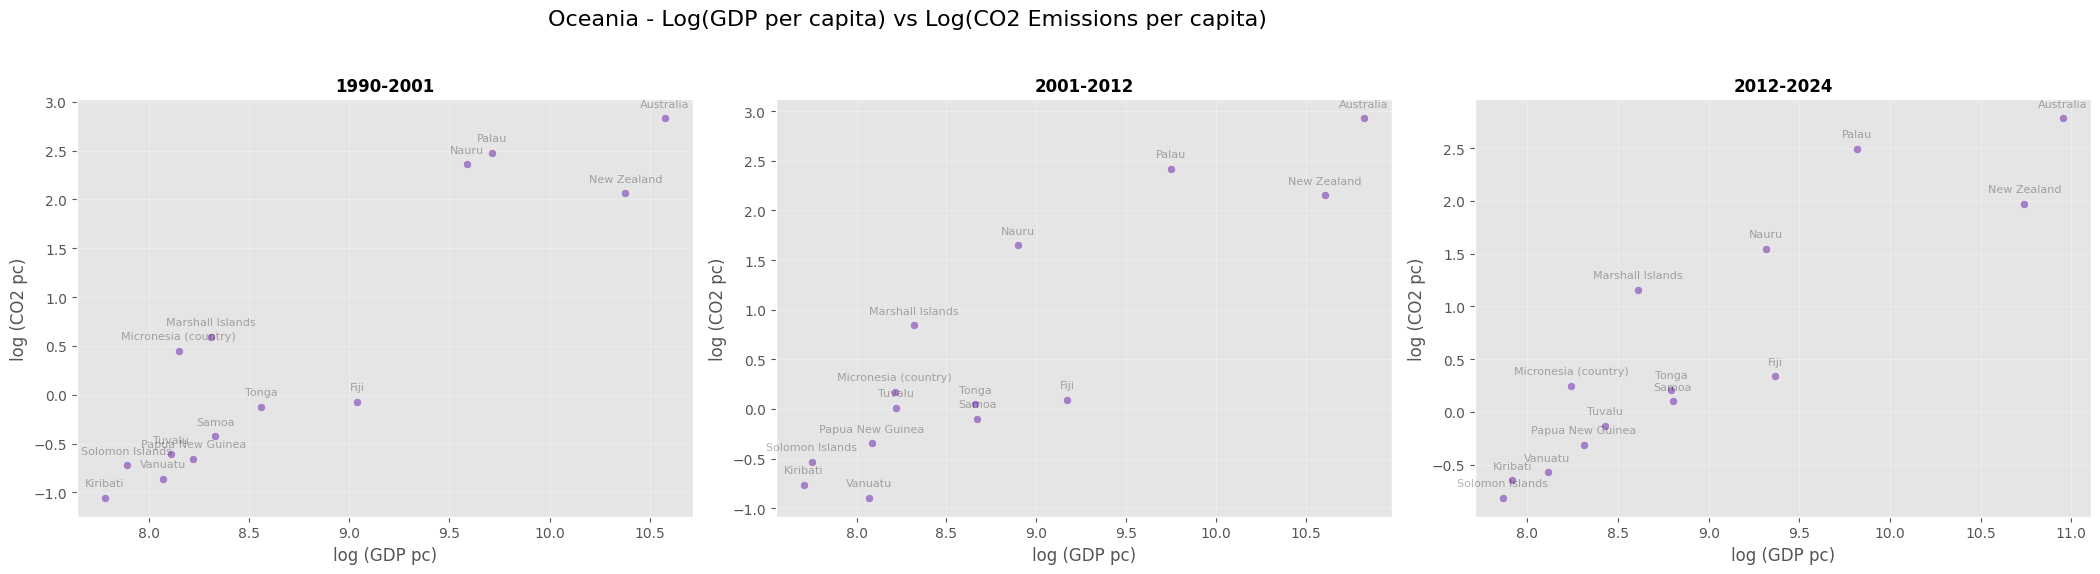

In [12]:
# Create scatterplots for each continent (Log(GDP per capita) vs Log(CO2 emissions per capita))
for continent in continents:
    current_color = continent_palette[continent]
    create_scatterplots(
        data=df,
        x_col='log (GDP pc)',
        y_col='log (CO2 pc)',
        title=f'{continent} - Log(GDP per capita) vs Log(CO2 Emissions per capita)',
        output_path=f'../plots/scatterplots/scatterplot_log_gdp_vs_log_co2_per_capita_{continent.lower().replace(" ", "_")}.png',
        filter_condition=lambda d, c=continent: d[d['Continent'] == c],
        figsize=(24, 6),
        color=current_color
    )